### import data and package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score, recall_score

warnings.filterwarnings('ignore')

In [2]:
train=pd.read_table('traininingdata.txt',sep=";")
test=pd.read_table('testdata.txt',sep=";")

# EDA

In [3]:
train.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no


### check whether there is null value

In [4]:
#classify the features into continuous type(ctn) and categorical type(ctg)
ctn_features=['age', 'balance','day','duration','campaign', 'pdays', 'previous']
ctg_features=['contact', 'default', 'education', 'housing', 'job', 'loan','marital', 'month', 'poutcome']

# Feature Engineering

- age

In [5]:
def age_to_categorical(data,age):
    age_group=pd.cut(age,bins=[0,25,40,60,100],labels=['<25','25-40','40-60','>60'])
    #inserting the age group after age and deleting it
    data.insert(0,'age_group',age_group)
    #dropping age column
    data.drop('age',axis=1,inplace=True)
    
    return data

- Duration

In [6]:
def duration_to_categorical(data,duration):
    duration_group=pd.cut(duration,bins=[0,300,600,5000],labels=['<300','300-600','>600'])
    #inserting the age group after age and deleting it
    data.insert(0,'duration_group',duration_group)
    #dropping age column
    data.drop('duration',axis=1,inplace=True)
    return data

- job

In [32]:
sort_job=train.groupby('job').apply(lambda x:sum(x.y=='yes')/len(x)).sort_values(axis=0)
sort_job

job
blue-collar      0.072911
housemaid        0.082653
entrepreneur     0.083333
services         0.086337
unknown          0.107759
technician       0.109619
self-employed    0.111975
admin.           0.124670
management       0.139698
unemployed       0.155981
retired          0.229879
student          0.281709
dtype: float64

In [8]:
low_level=tuple(sort_job[:4].index.values)
mid_level=tuple(sort_job[4:8].index.values)
advanced_level=tuple(sort_job[8:10].index.values)
high_level=tuple(sort_job[10:].index.values)
dict_levels={low_level:'low_level',mid_level:'mid_level',advanced_level:'advanced_level',high_level:'high_level'}

In [9]:
def job_to_subg(data):
    data.replace({'job':low_level},'low_level',inplace=True)
    data.replace({'job':mid_level},'mid_level',inplace=True)
    data.replace({'job':advanced_level},'advanced_level',inplace=True)
    data.replace({'job':high_level},'high_level',inplace=True)
    return data

In [ ]:
def job_to_subg(data):
    data.replace({'job':low_level},'low_level',inplace=True)
    data.replace({'job':mid_level},'mid_level',inplace=True)
    data.replace({'job':advanced_level},'advanced_level',inplace=True)
    data.replace({'job':high_level},'high_level',inplace=True)
    return data

- remove outliers of compaign

In [10]:
def compaign_outlier(df):
    # for yes class
    Q1 = df[df.y == 'yes'].campaign.quantile(0.25)
    Q3 = df[df.y == 'yes'].campaign.quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    filter = (((df.campaign < (Q1 - 1.5 * IQR)) |(df.campaign > (Q3 + 1.5 * IQR))) & (df.y == 'yes'))
    df = df[~filter]

    # for no class
    Q1 = df[df.y == 'no'].campaign.quantile(0.25)
    Q3 = df[df.y == 'no'].campaign.quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    filter = (((df.campaign < (Q1 - 1.5 * IQR)) |(df.campaign > (Q3 + 1.5 * IQR))) & (df.y == 'no'))
    df = df[~filter]
    
    return df

- pdays

In [11]:
def pdays_0(data):
    data.replace({'pdays':-1},0,inplace=True)
    return data

In [12]:
def ftr_eng(data):
    data=age_to_categorical(data,data.age)
    data=duration_to_categorical(data,data.duration)
    data=job_to_subg(data)
    #data=compaign_outlier(data)
    data=pdays_0(data)
    return data

In [46]:
train[train.pdays > 100 -1].groupby('pdays').apply(lambda x: sum(x.y == 'yes') / len(x))

pdays
100    0.416667
101    0.222222
102    0.241379
103    0.315789
104    0.282051
         ...   
828    1.000000
831    0.000000
850    0.000000
854    1.000000
871    0.000000
Length: 431, dtype: float64

In [50]:
np.quantile(train[train.pdays != -1].pdays, [0.25, 0.5, 0.75, 0.9])

array([131., 193., 327., 362.])

In [58]:
train[(train.pdays > 362) & (train.y == 'yes')].count()

age          161
job          161
marital      161
education    161
default      161
balance      161
housing      161
loan         161
contact      161
day          161
month        161
duration     161
campaign     161
pdays        161
previous     161
poutcome     161
y            161
dtype: int64

In [65]:
pdays_perc = train[(train.pdays != -1) & (train.pdays < 362)].groupby('pdays').apply(lambda x: sum(x.y == 'yes') / len(x)).reset_index(name='percentage')

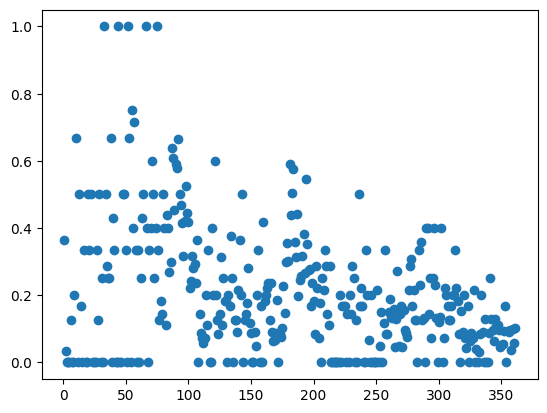

In [66]:
plt.scatter(pdays_perc.pdays, pdays_perc.percentage)

In [42]:
sum(train.pdays == -1)

29619

In [17]:
train=ftr_eng(train)
test=ftr_eng(test)

### Encoding

In [18]:
numeric_attrs = ['balance','day','campaign','pdays','previous']
bin_attrs = ['y','default','housing','loan']
cate_onehattrs = ['age_group','duration_group','job','marital','contact','poutcome']
cate_orderattrs=['education','month']

- binary

In [19]:
def encode_bin_attrs(data,bin_attrs):    
    for i in bin_attrs:
        data[i]=LabelEncoder().fit_transform(data[i])
    return data

- one-hot encoding

In [20]:
def encode_onehot_attrs(data,cate_onehattrs):
    for ftr in cate_onehattrs:
        data=pd.concat([data,pd.get_dummies(data[ftr],prefix=ftr)],axis=1)
    data=data.drop(columns=cate_onehattrs)
    return data

- ordinal encoding

In [21]:
def encode_edu_attrs(data):
    values = ['unknown','primary', 'secondary', 'tertiary']
    levels = range(0,len(values))
    dict_levels = dict(zip(values, levels))
    for v in values:
        data.loc[data['education'] == v, 'education'] = dict_levels[v]
    return data

def encode_month_attrs(data):
    values = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    levels = range(1,len(values)+1)
    dict_levels = dict(zip(values, levels))
    for v in values:
        data.loc[data['month'] == v, 'month'] = dict_levels[v]
    return data

In [22]:
def encode(data,bin_attrs,cate_onehattrs):
    data=encode_bin_attrs(data,bin_attrs)
    data=encode_onehot_attrs(data,cate_onehattrs)
    data=encode_edu_attrs(data)
    data=encode_month_attrs(data)
    return data

In [23]:
train=encode(train,bin_attrs,cate_onehattrs)
test=encode(test,bin_attrs,cate_onehattrs)

### split train and validation

In [24]:
train_data,valid_data=train_test_split(train,stratify=train['y'],test_size=0.2,random_state=1)
test_data=test

In [25]:
x_train,y_train=train_data.drop(columns='y'),train_data['y']
x_valid,y_valid=valid_data.drop(columns='y'),valid_data['y']
x_test,y_test=test_data.drop(columns='y'),test_data['y']

# Feature Scaling

In [26]:
scaler=StandardScaler().fit(x_train) 
def stdscl(data,scaler):
    data=scaler.transform(data)
    return data


In [27]:
x_train[:]=stdscl(x_train,scaler)
x_valid[:]=stdscl(x_valid,scaler)
x_test[:]=stdscl(x_test,scaler)

# Resampling

In [28]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.6,random_state=1)
x_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

In [33]:
print(len(x_test), len(y_test))

9043 9043


In [30]:
from sklearn.ensemble import RandomForestClassifier

RFCls = RandomForestClassifier(n_estimators=400, random_state=5101)
RFCls.fit(x_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=5101)

In [34]:
RFProba = RFCls.predict_proba(x_test)
RFPrediction = (RFProba[:,-1] > 0.4).astype('int')

In [40]:
precision_score(y_test, RFPrediction)

0.538

In [36]:
RFCls_sampled = RandomForestClassifier(n_estimators=400, random_state=5101)
RFCls_sampled.fit(x_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(n_estimators=400, random_state=5101)

In [38]:
RFProba_sampled = RFCls_sampled.predict_proba(x_test)
RFPrediction_sampled = (RFProba_sampled[:,-1] > 0.4).astype('int')

In [39]:
precision_score(y_test, RFPrediction_sampled)

0.4996237772761475